In [1]:
import numpy as np 
import matplotlib.pyplot as plt

import torch
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
from pytorch_lightning import Trainer

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from pathlib import Path

from dataset import MushroomBodyDataset 
from rnn import NeuralRNNModule

%load_ext autoreload
%aimport dataset, rnn
%autoreload 1

Datum shape for input and output is (timesteps, neurons): torch.Size([10, 15])


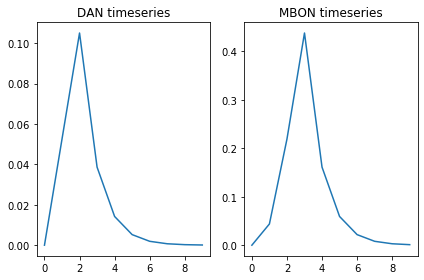

In [2]:
dataset = MushroomBodyDataset()

print(f'Datum shape for input and output is (timesteps, neurons): {dataset[0]["dan"].shape}')

fig, axs = plt.subplots(1,2)
axs[0].plot(dataset[0]["dan"][:,0])
axs[0].set_title('DAN timeseries')
axs[1].plot(dataset[0]["mbon"][:,0])
axs[1].set_title('MBON timeseries')
plt.tight_layout()
plt.show()

In [3]:
num_samples = len(dataset.data)
train_percentage, val_percentage = 0.6, 0.2
test_percentage = 1 - train_percentage - val_percentage

lengths = [
    int(train_percentage * num_samples), 
    int(val_percentage * num_samples),
    int(test_percentage * num_samples),
]

train_dataset, val_dataset, test_dataset = random_split(dataset, lengths, generator=torch.Generator().manual_seed(42))

print(f'Train dataset size: {len(train_dataset)}')
print(f'Val dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

Train dataset size: 5400
Val dataset size: 1800
Test dataset size: 1800


# Hyperparams

In [4]:
hparams = {
    'batch_size': 8,
    'lr': 0.00005,
    'non_linearity': 'tanh',
    'max_epochs': 20,
    'min_epochs': 1
}

# Create Dataloaders

In [5]:
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=hparams['batch_size'],
    shuffle=False, 
    num_workers=4
)

val_dataloader = DataLoader(
    val_dataset, 
    batch_size=hparams['batch_size'],
    shuffle=False, 
    num_workers=4
)

# Load Masks

In [6]:
import matplotlib.pyplot as plt

greek_lobes = [
    r"$\alpha'_1$", r"$\alpha'_2$", r"$\alpha'_3$", 
    r'$\alpha_1$', r'$\alpha_2$', r'$\alpha_3$', 
    r"$\beta'_1$", r"$\beta'_2$",
    r'$\beta_1$', r'$\beta_2$', 
    r'$\gamma_1$', r'$\gamma_2$', r'$\gamma_3$', r'$\gamma_4$', r'$\gamma_5$'
]

In [7]:
def plot_matrix(matrix, labels, title, cbar_title=None, size=[8,8], switch=False):
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(matrix)


    plt.yticks(range(len(labels)), labels)
    plt.xticks(range(len(labels)), labels)
    plt.title(title)
    if switch:
        plt.xlabel('Target')
        plt.ylabel('Source')
    else:
        plt.xlabel('Source')
        plt.ylabel('Target')
    # Loop over data dimensions and create text annotations.
    for i in range(len(labels)):
        for j in range(len(labels)):
            col = 'white' if matrix[i, j] < matrix.max()/2 else 'black'
            text = ax.text(j, i, int(matrix[i, j]),
                           ha="center", va="center", color=col)

    # Create colorbar
    if cbar_title is not None:
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel(cbar_title, rotation=-90, va="bottom")

    plt.tight_layout()
    plt.show()

In [8]:
mbon2mbon_connectome = np.load('../data/mbon-connectomics.npy')

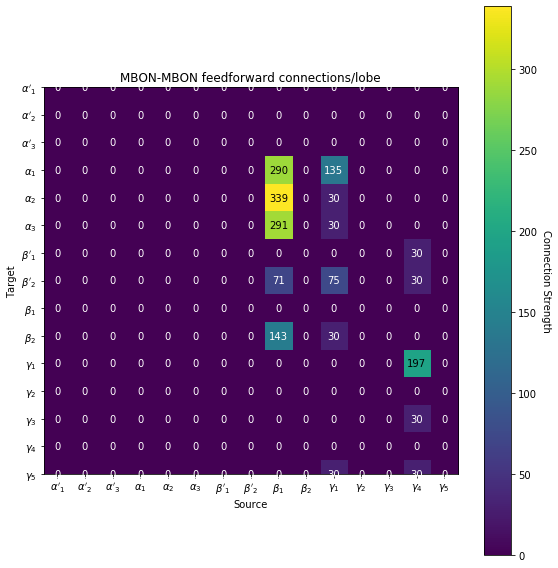

In [9]:
plot_matrix(
    mbon2mbon_connectome, 
    greek_lobes, 
    'MBON-MBON feedforward connections/lobe', 
    'Connection Strength'
)

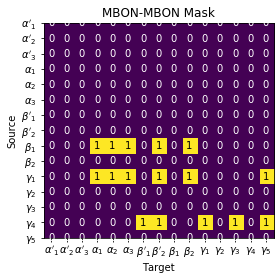

In [10]:
mbon_mask = torch.from_numpy((mbon2mbon_connectome > 0)*1.0)
plot_matrix(
    mbon_mask.t(), 
    greek_lobes, 
    'MBON-MBON Mask',
    size=[4,4],
    switch=True
)

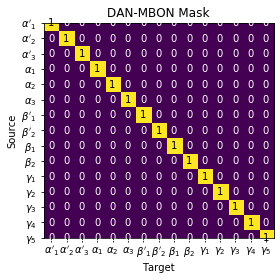

In [11]:
dan_mask = torch.from_numpy(np.diag(np.ones(15)))
plot_matrix(
    dan_mask.t(), 
    greek_lobes, 
    'DAN-MBON Mask',
    size=[4,4],
    switch=True
)

# Instantiate Model

In [12]:
model = NeuralRNNModule(
    masked=True,                           # if using masks for Wxh and Whh
    lr=hparams['lr'],                      # learning rate
    input_mask=dan_mask.t(),               # mask shape (in_dans, out_mbons) = (15,15)
    hidden_mask=mbon_mask.t(),             # mask shape (in_mbons, out_mbons) = (15,15)
    non_linearity=hparams['non_linearity'] # relu or tanh
)

model.hparams

"lr":            5e-05
"masked":        True
"non_linearity": tanh

In [13]:
# Check that the forward pass does what I expect
batch = next(iter(train_dataloader))
output = model(batch['dan'])
output.shape    # (batch, sequnce length, nodes)

torch.Size([8, 10, 15])

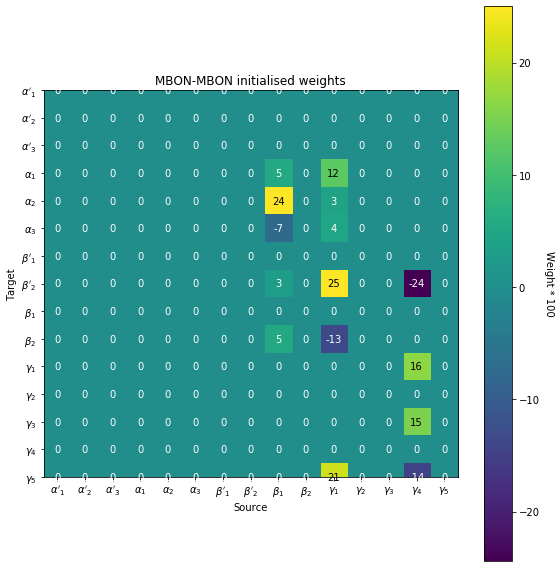

In [14]:
# Check the masked/unmasked weights before training
M = model.rnn.W_hh.weight.detach().numpy() * 100
plot_matrix(
    M, 
    greek_lobes, 
    'MBON-MBON initialised weights', 
    'Weight * 100',
    switch=False
)

# Lets Try Train

In [15]:
logger = TensorBoardLogger("tb_logs", name="masked_rnn", default_hp_metric=False)

In [16]:
logger.log_hyperparams(hparams)

In [17]:
trainer = Trainer(
    logger=logger,
    max_epochs=hparams['max_epochs'],
    min_epochs=hparams['min_epochs'],
    callbacks=[EarlyStopping(monitor='val/loss')]
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [18]:
trainer.fit(model, train_dataloader, val_dataloader)

900 [00:25<00:05, 28.85it/s, loss=0.00689, v_num=9]
Epoch 11:  75%|███████▌  | 676/900 [00:24<00:08, 27.38it/s, loss=0.00675, v_num=9]
Validating: 0it [00:00, ?it/s]
Epoch 12:  75%|███████▌  | 676/900 [00:26<00:08, 25.80it/s, loss=0.0066, v_num=9]
Validating: 0it [00:00, ?it/s]
Epoch 13:  75%|███████▌  | 676/900 [00:23<00:07, 28.24it/s, loss=0.00645, v_num=9]
Validating: 0it [00:00, ?it/s]
Epoch 14:  75%|███████▌  | 676/900 [00:24<00:07, 28.12it/s, loss=0.0063, v_num=9]
Validating: 0it [00:00, ?it/s]
Epoch 15:  75%|███████▌  | 676/900 [00:25<00:08, 26.87it/s, loss=0.00616, v_num=9]
Validating: 0it [00:00, ?it/s]
Epoch 16:  75%|███████▌  | 676/900 [00:24<00:08, 27.33it/s, loss=0.00602, v_num=9]
Validating: 0it [00:00, ?it/s]
Epoch 17:  75%|███████▌  | 676/900 [00:23<00:07, 29.21it/s, loss=0.00589, v_num=9]
Validating: 0it [00:00, ?it/s]
Epoch 18:  75%|███████▌  | 676/900 [00:22<00:07, 29.63it/s, loss=0.00577, v_num=9]
Validating: 0it [00:00, ?it/s]
Epoch 19:  75%|███████▌  | 676/900 [00

# Save model

In [21]:
torch.save(model.state_dict(), MODEL_PATH)

# Load model (optional)

In [15]:
# Load model for inference using:

MODEL_PATH = Path('../models/masked_rnn.pt')
model = NeuralRNNModule(
    masked=True,                           # if using masks for Wxh and Whh
    lr=hparams['lr'],                      # learning rate
    input_mask=dan_mask.t(),               # mask shape (in_dans, out_mbons) = (15,15)
    hidden_mask=mbon_mask.t(),             # mask shape (in_mbons, out_mbons) = (15,15)
    non_linearity=hparams['non_linearity'] # relu or tanh
)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

NeuralRNNModule(
  (rnn): MaskedNeuralRNN(
    (W_xh): CustomizedLinear(input_features=15, output_features=15, bias=True)
    (W_hh): CustomizedLinear(input_features=15, output_features=15, bias=True)
    (activation): Tanh()
  )
  (loss_fcn): MSELoss()
)

# Visualise the trained weights

In [16]:
def normalise(m):
    if m.min() < 0:
        return (m - m.min() )/ (m.max() - m.min())
    
    return m / m.max()

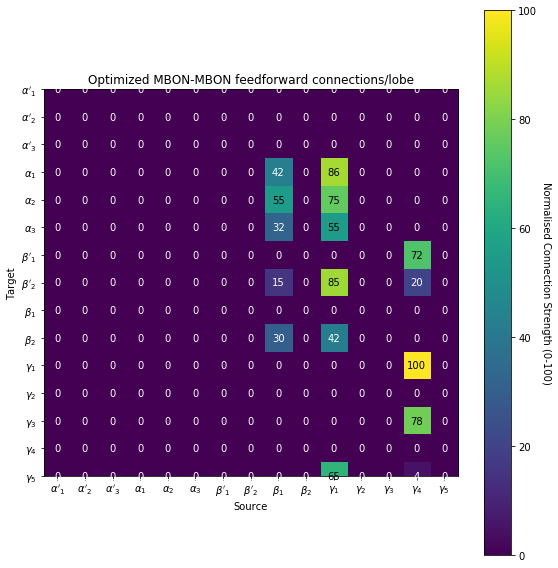

In [17]:
# multiply by 100 for visulisation purposes
M = normalise(model.rnn.W_hh.weight.detach().numpy()) * 100
plot_matrix(
    M, 
    greek_lobes, 
    'Optimized MBON-MBON feedforward connections/lobe', 
    'Normalised Connection Strength (0-100)'
)

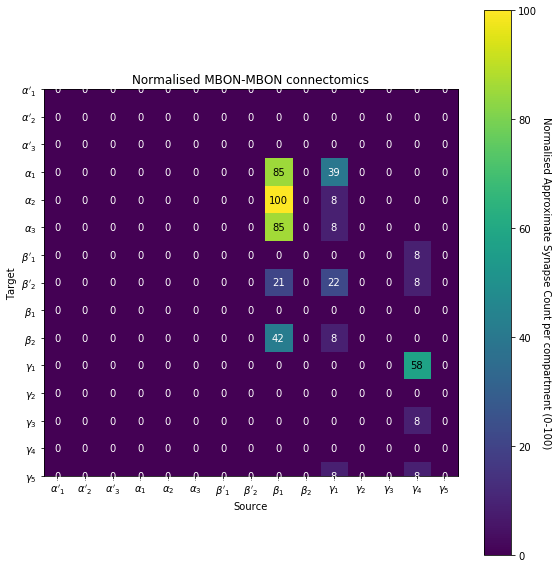

In [18]:
# multiply by 100 for visulisation purposes
M = normalise(mbon2mbon_connectome) * 100
plot_matrix(
    M, 
    greek_lobes, 
    'Normalised MBON-MBON connectomics', 
    'Normalised Approximate Synapse Count per compartment (0-100)'
)

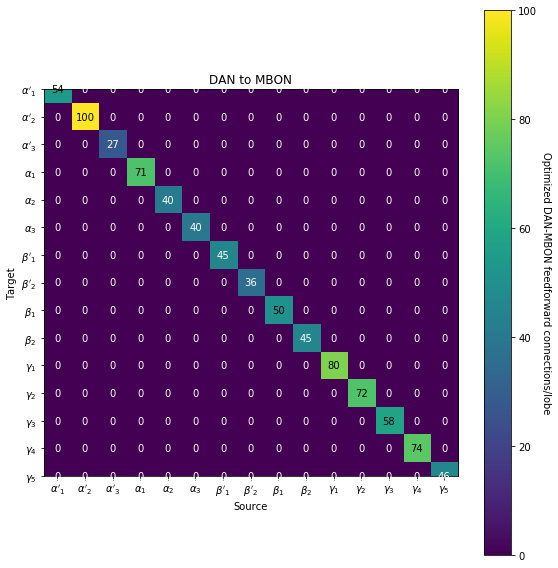

In [19]:
# multiply by 100 for visulisation purposes
M = normalise(model.rnn.W_xh.weight.detach().numpy()) * 100
plot_matrix(
    M, 
    greek_lobes, 
    'DAN to MBON', 
    'Optimized DAN-MBON feedforward connections/lobe'
)


# Inspect shape of the output

In [20]:
 model.eval()

NeuralRNNModule(
  (rnn): MaskedNeuralRNN(
    (W_xh): CustomizedLinear(input_features=15, output_features=15, bias=True)
    (W_hh): CustomizedLinear(input_features=15, output_features=15, bias=True)
    (activation): Tanh()
  )
  (loss_fcn): MSELoss()
)

In [21]:
test_dataloader = DataLoader(
    test_dataset, 
    batch_size=1,
    shuffle=False, 
    num_workers=4
)

batch = next(iter(test_dataloader))
output = model(batch['dan'])

print(output.shape)

torch.Size([1, 10, 15])


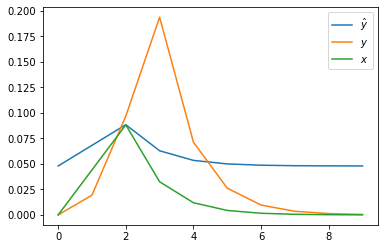

In [22]:
compartment = 11
plt.plot(output[0,:,compartment].detach().numpy(), label=r'$\hat y$')
plt.plot(batch['mbon'][0,:,compartment], label=r'$y$')
plt.plot(batch['dan'][0,:,compartment], label=r'$x$')

plt.legend()
plt.show()

# Testing

In [24]:
model.eval()

loss_fcn = nn.MSELoss()

test_dataloader = DataLoader(
    test_dataset, 
    batch_size=1,
    shuffle=False, 
    num_workers=4
)

In [25]:
batch = next(iter(test_dataloader))

In [26]:
test_loss = 0
for batch in test_dataloader:
    x = batch['dan']
    y = batch['mbon']
    y_pred = model(x)
    test_loss += loss_fcn(y, y_pred)
av_test_loss = test_loss / len(test_dataloader)

In [27]:
av_test_loss.detach().numpy()

array(0.00559279, dtype=float32)

In [49]:
test_loss.requires_grad


True

In [52]:
x.requires_grad

False